In [11]:
import torch
from linreg_data import generate_parameters, generate_data
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## What this notebook contains

The goal of this notebook is to set-up one of the key experiments contained in my paper. The overall idea is that even when the ground-truth data is generated as a linear regression, the alternating minimization-grad descent scheme is very suboptimal, even when you overparameterize the representation as a powerful neural network (compared to the ground truth representation, which is just a matrix in this case).

To put some math into this, we assume that our data is generated as:
\begin{align*}
    y^{(t)}_i = F^{(t)}_\star \Phi_\star x^{(t)}_i + w^{(t)}_i,\quad y^{(t)}_i \in \mathbb R^{d_y}, x^{(t)}_i \in \mathbb R^{d_x}, \Phi_\star \in \mathbb R^{r \times d_x}.
\end{align*}
where $t$ indexes distinct tasks $t = 1,\dots, T$. For normalization purposes, we assume $\Phi_\star$ has orthonormal rows. In this set of experiments, we simplify things and assume $x^{(t)}_i$ and $w^{(t)}_i$ are independent and identically distributed across all tasks:
\begin{align*}
    x_i^{(t)} \sim \mathcal N (0, \Sigma_x),\;\; w_i^{(t)} \sim \mathcal N(0, \sigma^2 \cdot \mathrm{Id}), \quad \text{for all }i,t.
\end{align*}
Notably, $\Sigma_x \succ 0$ is going to be generated as some covariance matrix that is *non-isotropic*, i.e. not Identity (or any constant scaling of it. We can take a peek at the data generation functions we imported: `from linreg_data import generate_parameters, generate_data`.

In [12]:
def generate_parameters(dx, dy, r, num_tasks):

    # randomly generate covariance of x
    U = 5*torch.eye(dx) + torch.randn(dx, dx)
    Sigma_x = 0.5*(U + U.T)                                # Make Sigma_x symmetric
    Sigma_x = (dx / torch.trace(Sigma_x)) * Sigma_x        # normalize to get Tr(Sigma_x) = dx
    
    # randomly generate representation Phi*
    A = torch.randn(r, dx)
    _, _, Phi = torch.linalg.svd(A, full_matrices = False) # Generate Phi* as random matrix that is then orthonormalized.
    
    # randomly generate heads F0 (for validation), F1,...,FT (for training)
    F0 = torch.randn(dy, r)
    Fs = []
    Fs.append(F0)
    for i in range(num_tasks):
        gamma = 0.01
        B = torch.randn(dy, dy)
        rot = torch.linalg.matrix_exp(0.5*gamma*(B - B.T)) # Generate heads by randomly applying a rotation to F0
        F = rot @ F0
        Fs.append(F)
    
    return Fs, Phi, Sigma_x

As one can glean above, the `generate_parameters` is an exceedingly simple way to randomly generate the key parameters of the ground-truth data, which are the heads $F^{(1)},\dots, F^{(T)}$, the representation $\Phi_\star$ and the *non-isotropic* data covariance $\Sigma_x$.

The following function `generate_data` simply generates data $(x^{(t)}_i, y_i^{(t)})$ from said parameters.

In [13]:
def generate_data(n_points, Fs, Phi, cov_x, mode = 'train'):
    
    U, S, V = torch.linalg.svd(cov_x)
    cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
    dy = Fs[0].shape[0]
    dx = Phi.shape[-1]

    if mode == 'train':
        X = []
        Y = []
        for i in range(1, len(Fs)):                       # for each task 1,...,T
            M = Fs[i] @ Phi
            xs = cov_x_sqrt @ torch.randn(dx, n_points)
            ws = 0.1*torch.randn(dy, n_points)
            ys = M @ xs + ws

            X.append(xs)
            Y.append(ys)
        return X, Y
    
    elif mode == 'test':
        M = Fs[0] @ Phi
        xs = cov_x_sqrt @ torch.randn(dx, n_points)
        ws = torch.randn(dy, n_points)
        ys = M @ xs + ws

        return xs, ys

The only trick we used here is a property of Gaussian random vectors: $x \sim \mathcal N(0, \Sigma_x)$ is equivalent to $x = \Sigma_x^{1/2} v$, $v \sim \mathcal N(0, \mathrm{Id})$.

With parameter generation and data generation in hand, let us describe the experiment. For each batch of data, we run 4 algorithms/models, all falling under the alternating minimization-descent paradigm. By this we mean, for each update iteration:
1. **(Minimization)** Hold current rep. $\hat\Phi(\cdot)$ fixed. For each task compute the (rep-conditioned) least-squares head:
\begin{align*}
\hat F^{(t)} = \argmin_F \sum_{i=1}^{\texttt{n\_points}} \|y_i^{(t)} - F \hat\Phi (x_i^{(t)}) \|^2.
\end{align*}
2. **(Descent)** Hold the least-squares heads $\hat F^{(1)}, \dots, \hat F^{(T)}$ fixed. Perform a descent step (whatever that may look like depending on the algorithm) on the representation. We usually assume this update can be computed locally for each task and averaged to yield the final update (this is certainly true for grad descent, since $\nabla $ is a linear operator).
\begin{align*}
d^{(t)} &= \mathrm{DescentStep}(\hat\Phi; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} ), \quad \text{for }t = 1,\dots, T \\
\hat\Phi^{(t)}_{\mathrm{next}} &= \hat\Phi - \eta d^{(t)} \\
\hat\Phi_{\mathrm{next}} &= \frac{1}{T}\sum_{t=1}^T \hat\Phi^{(t)}_{\mathrm{next}} \\
\text{(For certain methods) }\hat\Phi_{\mathrm{next}} &= \mathrm{Postprocess}(\hat\Phi_{\mathrm{next}}).
\end{align*}

The four algorithms/models are:
1. De-bias and Feature-Whiten (DFW). This is the algorithm from my paper. 
   - Rep model: linear rep, i.e. well-specified ($\mathrm{dim}(\Phi) = \mathrm{dim}(\Phi_\star)$)
   - Descent step: $d^{(t)} = \underbrace{\nabla_\Phi(\hat\Phi; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} )}_{\text{standard (stochastic) gradient, holding } F^{(t)} \text{ fixed}.} \cdot \underbrace{\left(\frac{1}{\texttt{n\_points}} \sum_{i=1}^{\texttt{n\_points}} x_i^{(t)}{x_i^{(t)}}^\top \right)^{-1}}_{\text{precondition by inverse sample covariance}}$.
2. (Well-specified) alternating minimization-descent.
   - Rep model: linear rep, i.e. well-specified ($\mathrm{dim}(\Phi) = \mathrm{dim}(\Phi_\star)$)
   - Descent step: $d^{(t)} = \underbrace{\nabla_\Phi(\hat\Phi; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} )}_{\text{standard (stochastic) gradient, holding } F^{(t)} \text{ fixed}.}$
3. 1-hidden layer neural net + alternating minimization-descent.
   - Rep model: 1-hidden layer ReLU-net. 
   - Descent step: $d^{(t)} = \nabla_\theta(\hat\Phi_\theta; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} )$,    $\theta$ are params of neural net.
4. 2-hidden layer neural net + alternating minimization-descent.
   - Rep model: 2-hidden layer ReLU-net. 
   - Descent step: $d^{(t)} = \nabla_\theta(\hat\Phi_\theta; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} )$,    $\theta$ are params of neural net.

In [14]:
# training loop params
n_experiments = 20                # number of iterations we run the pipeline (for error bars)
num_iter = 4000                     # number of descent steps

dy = 15
dx = 50
r = 5
num_tasks = 10
n_points = 200

DFW_lr = 0.01
AMDD_lr = 0.01
MLP_lr = 0.01
d_hidden = 64                      # note this is > dy, dx

DFW_all = []
AMGD_all = []                      # AMGD stands for alternating-minimization gradient-descent
AMDD_all = []                      # AMDD stands for alternating-minimization double-descent
alt_mlp1_all = []
alt_mlp2_all = []
optimal_loss_all = []

In [15]:
for k in range(n_experiments):
    print(f"Experiment #{k+1}")  
    Fs, Phi, Sigma_x = generate_parameters(dx, dy, r, num_tasks)
    mlp_rep_alt1 = nn.Sequential(nn.Linear(dx, d_hidden), nn.ReLU(), 
                            nn.Linear(d_hidden, d_hidden), nn.ReLU(), nn.Linear(d_hidden, r))
    mlp_rep_alt2 = nn.Sequential(nn.Linear(dx, d_hidden), nn.ReLU(), nn.Linear(d_hidden, d_hidden), nn.ReLU(),
                            nn.Linear(d_hidden, d_hidden), nn.ReLU(), nn.Linear(d_hidden, r))
    
    # pytorch optimizers for the MLPs
    opt_alt1 = torch.optim.SGD(list(mlp_rep_alt1.parameters()), lr=MLP_lr)
    opt_alt2 = torch.optim.SGD(list(mlp_rep_alt2.parameters()), lr=MLP_lr)
    _, _, Phi_est_DFW = torch.linalg.svd(torch.randn(r, dx), full_matrices = False)
    _, _, Phi_est_AMGD = torch.linalg.svd(torch.randn(r, dx), full_matrices = False)
    _, _, Phi_est_AMDD = torch.linalg.svd(torch.randn(r, dx), full_matrices = False)

    # Generate validation data since we don't know ground-truth optimal parameters for MLPs
    Xs_val, Ys_val = generate_data(1000, Fs, Phi, Sigma_x, mode='test')

    DFW_losses = []
    AMGD_losses = []
    alt_mlp1_losses = []
    alt_mlp2_losses= []
    optimal_losses = []
    AMDD_losses = []
    AMDD_heads = []

    for k in range(num_iter):
        # initialize F_AMDD (for each head)
        init_F = torch.randn(dy, r) 
        AMDD_heads.append(init_F)         

    optimal_losses.append((1/1000*torch.linalg.norm(Ys_val - Fs[0] @ Phi @ Xs_val)**2).item())

    for k in range(num_iter):
        # generate batch of task data
        Xs, Ys = generate_data(n_points, Fs, Phi, Sigma_x, mode='train')
        mlp_rep_alt1.train()
        mlp_rep_alt2.train()

        # alternating step 1: compute rep-conditioned least-squares weights
        mlp_alt_loss1 = 0
        mlp_alt_loss2 = 0
        Phi_next_DFW = Phi_est_DFW
        Phi_next_AMGD = Phi_est_AMGD
        Phi_next_AMDD = Phi_est_AMDD
        for h in range(num_tasks):
            X_h1 = Xs[h][:,:n_points//2]          # set aside half of batch to compute heads, other half for rep
            Y_h1 = Ys[h][:,:n_points//2]
            X_h2 = Xs[h][:,n_points//2:]
            Y_h2 = Ys[h][:,n_points//2:]

            # DFW
            Z_h1 = Phi_est_DFW @ X_h1
            F_h = torch.linalg.lstsq(Z_h1.mT, Y_h1.mT).solution.mT
            lstsq_sol = torch.linalg.lstsq(X_h2.mT, Y_h2.mT).solution.mT
            DFWGradPhi_h = F_h.mT @ (F_h @ Phi_est_DFW - lstsq_sol)  # closed-form DFW gradient update; avoids inverse calcs
            Phi_next_DFW = Phi_next_DFW - (DFW_lr/num_tasks) * DFWGradPhi_h

            # AMGD Linear
            Z_h1 = Phi_est_AMGD @ X_h1
            F_h = torch.linalg.lstsq(Z_h1.mT, Y_h1.mT).solution.mT
            AMGDGradPhi_h = F_h.mT @ (F_h @ Phi_est_AMGD @ X_h2 - Y_h2) @ X_h2.mT
            Phi_next_AMGD = Phi_next_AMGD - (DFW_lr/num_tasks) * AMGDGradPhi_h

            # AMDD
            Z_h1 = Phi_est_AMDD @ X_h1
            AMDDGradF_h = (AMDD_heads[k] @ Z_h1 - Y_h1) @ Z_h1.mT
            AMDDGradPhi_h = AMDD_heads[k].mT @ (AMDD_heads[k] @ Phi_est_AMGD @ X_h2 - Y_h2) @ X_h2.mT
            # descent steps
            Phi_next_AMDD = Phi_next_AMDD - (AMDD_lr/num_tasks) * AMDDGradPhi_h
            AMDD_heads[k] = AMDD_heads[k] - (AMDD_lr/num_tasks) * AMDDGradF_h
            
            # Alt SGD 1-hidden layer MLP
            Z_h1_MLP_T = mlp_rep_alt1(X_h1.mT)
            F_h_MLP = torch.linalg.lstsq(Z_h1_MLP_T, Y_h1.mT).solution.mT
            mlp_alt_loss1 += 2/(num_tasks*n_points) * torch.linalg.norm(Y_h2 - F_h_MLP @ mlp_rep_alt1(X_h2.mT).mT)**2

            # Alt SGD 2-hidden layer MLP
            Z_h1_MLP_T = mlp_rep_alt2(X_h1.mT)
            F_h_MLP = torch.linalg.lstsq(Z_h1_MLP_T, Y_h1.mT).solution.mT
            mlp_alt_loss2 += 2/(num_tasks*n_points) * torch.linalg.norm(Y_h2 - F_h_MLP @ mlp_rep_alt2(X_h2.mT).mT)**2    
        
        # DFW rep update
        _,_,Phi_est_DFW = torch.linalg.svd(Phi_next_DFW, full_matrices=False)
        _,_,Phi_est_AMGD = torch.linalg.svd(Phi_next_AMGD, full_matrices=False)
        _,_,Phi_est_AMDD = torch.linalg.svd(Phi_next_AMDD, full_matrices=False)

        # MLP rep update
        mlp_alt_loss1.backward()
        opt_alt1.step()
        mlp_alt_loss2.backward()
        opt_alt2.step()

        # validation
        mlp_rep_alt1.eval()
        mlp_rep_alt2.eval()

        # DFW
        Zs_val = Phi_est_DFW @ Xs_val
        F_val = torch.linalg.lstsq(Zs_val.mT, Ys_val.mT).solution.mT
        DFW_val = 1/1000*torch.linalg.norm(Ys_val - F_val @ Zs_val)**2
        DFW_losses.append(DFW_val.item())

        Zs_val = Phi_est_AMGD @ Xs_val
        F_val = torch.linalg.lstsq(Zs_val.mT, Ys_val.mT).solution.mT
        AMGD_val = 1/1000*torch.linalg.norm(Ys_val - F_val @ Zs_val)**2
        AMGD_losses.append(AMGD_val.item())

        Zs_val = Phi_est_AMDD @ Xs_val
        F_val = torch.linalg.lstsq(Zs_val.mT, Ys_val.mT).solution.mT
        AMDD_val = 1/1000*torch.linalg.norm(Ys_val - F_val @ Zs_val)**2
        AMDD_losses.append(AMDD_val.item())

        Zs_val_MLP_T = mlp_rep_alt1(Xs_val.mT).detach()
        F_val_MLP = torch.linalg.lstsq(Zs_val_MLP_T, Ys_val.mT).solution.mT
        alt_mlp_val = 1/1000*torch.linalg.norm(Ys_val - F_val_MLP @ Zs_val_MLP_T.mT)**2
        alt_mlp1_losses.append(alt_mlp_val.item())

        Zs_val_MLP_T = mlp_rep_alt2(Xs_val.mT).detach()
        F_val_MLP = torch.linalg.lstsq(Zs_val_MLP_T, Ys_val.mT).solution.mT
        alt_mlp_val = 1/1000*torch.linalg.norm(Ys_val - F_val_MLP @ Zs_val_MLP_T.mT)**2
        alt_mlp2_losses.append(alt_mlp_val.item())

        opt_alt1.zero_grad()
        opt_alt2.zero_grad()

    DFW_all.append(DFW_losses)
    AMGD_all.append(AMGD_losses)
    AMDD_all.append(AMDD_losses)
    alt_mlp1_all.append(alt_mlp1_losses)
    alt_mlp2_all.append(alt_mlp2_losses)

Experiment #1
Experiment #2
Experiment #3
Experiment #4
Experiment #5
Experiment #6
Experiment #7
Experiment #8
Experiment #9
Experiment #10
Experiment #11
Experiment #12
Experiment #13
Experiment #14
Experiment #15
Experiment #16
Experiment #17
Experiment #18
Experiment #19
Experiment #20


In [16]:
DFW_median = np.median(np.array(DFW_all), axis = 0)
AMGD_median = np.median(np.array(AMGD_all), axis = 0)
AMDD_median = np.median(np.array(AMDD_all), axis = 0)
alt_mlp1_median = np.median(np.array(alt_mlp1_all), axis = 0)
alt_mlp2_median = np.median(np.array(alt_mlp2_all), axis = 0)
optimal_median = np.median(np.array(optimal_losses))

DFW_quantiles = np.quantile(np.array(DFW_all), q=[0.1, 0.9], axis = 0)
AMGD_quantiles = np.quantile(np.array(AMGD_all),q=[0.1, 0.9], axis = 0)
AMDD_quantiles = np.quantile(np.array(AMDD_all), q=[0.1, 0.9], axis = 0)
alt_mlp1_quantiles = np.quantile(np.array(alt_mlp1_all), q=[0.1, 0.9], axis = 0)
alt_mlp2_quantiles = np.quantile(np.array(alt_mlp2_all), q=[0.1, 0.9], axis = 0)
optimal_quantiles = np.quantile(np.array(optimal_losses), q=[0.1, 0.9])

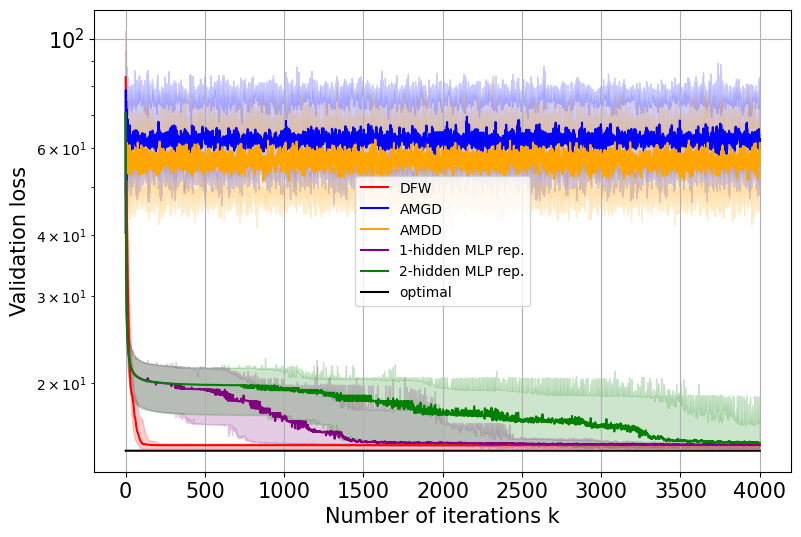

In [17]:
iter = np.arange(1, num_iter+1)
plt.figure(figsize=(9,6))
plt.plot(iter, DFW_median, label="DFW", color='red')
plt.plot(iter, AMGD_median, label="AMGD", color='blue')
plt.plot(iter, AMDD_median, label="AMDD", color='orange')
plt.plot(iter, alt_mlp1_median, label='1-hidden MLP rep.', color='purple')
plt.plot(iter, alt_mlp2_median, label='2-hidden MLP rep.', color='green')
plt.plot(iter, optimal_median*np.ones_like(iter), label="optimal", color = 'black')
plt.fill_between(iter, DFW_quantiles[0], DFW_quantiles[1], color='red', alpha=0.2)
plt.fill_between(iter, AMGD_quantiles[0], AMGD_quantiles[1], color='blue', alpha=0.2)
plt.fill_between(iter, AMDD_quantiles[0], AMDD_quantiles[1], color='orange', alpha=0.2)
plt.fill_between(iter, alt_mlp1_quantiles[0], alt_mlp1_quantiles[1], color='purple', alpha=0.2)
plt.fill_between(iter, alt_mlp2_quantiles[0], alt_mlp2_quantiles[1], color='green', alpha=0.2)

plt.ylabel(r'Validation loss',fontsize=15)
plt.xlabel('Number of iterations k',fontsize=15)
plt.yscale("log")
plt.tick_params(axis='both', labelsize=15)
plt.legend()
# # Exclude the shading elements from the legend
# handles, labels = plt.gca().get_legend_handles_labels()
# handles = handles[:4]  # Keep only the handles for the curve lines
# labels = labels[:4]  # Keep only the labels for the curve lines
# plt.legend(handles=handles, labels=labels,fontsize=20)
# plt.subplots_adjust(bottom=0.20)
plt.grid()
# plt.savefig('NN.pdf')
plt.show()

Here we see that AMGD on a linear representation is utterly useless. On the other hand, the MLPs do eventually converge, but take much longer, and generally are much noisier. We also see the curious phenomenon where the number of "feature learning" plateaus seen by the MLPs is proportional to the number of hidden layers. This goes in the opposite direction of what we should expect of adding more layers, where the "benign overparameterization" literature implies more layers makes the optimization landscape *better*, not worse.